## Extracting the LSST-reprocessed Summer 2013 Stripe 82 photometry for a given object.  

We show the steps for an object SDSS J013007.13+002635.4 , a carbon star at [(ra,dec) = (22.529730609, 0.443172890)](http://skyserver.sdss.org/dr12/en/tools/explore/summary.aspx?ra=01+30+07.1&dec=00+26+35.4)



In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from astropy import units as u
from astropy.table import Table
from astropy.table import vstack
from astropy.table import hstack
from astropy.coordinates import SkyCoord
from astropy import version
from astropy.io import ascii

### Single Object : Figure out which path ... 

SDSS S82 is divided into patches labeled (I,J), with I index running along RA from right to left (with values 0:409), and J index running along DEC from bottom to top (with values 0 to 11). 

In [ ]:
# finding patch in which desired object lays .
ra = 22.5297306
dec = 0.443172890
patch_bounds = pd.read_table('../raw_data/repo_fls/coaddBounds.txt', 
                             delim_whitespace=True)
mask_ra = (patch_bounds['maxRA'].values<ra)*(ra < patch_bounds['minRA'].values)
mask_dec = (patch_bounds['minDec'].values<dec)*(dec < patch_bounds['maxDec'].values)
mask = mask_ra * mask_dec
patch_bounds[mask]

Patches are aggregated along I index (as in ../packages/LC_processing.py ) : 

 NCSA : 
 
    ['00_21', '22_43','44_65', '66_87' ,'88_109','110_131',
    '132_153', '154_175',  '176_181', '365_387', '388_409'] 

  IN2P3 : 
    
    ['155_176', '176_197','197_218', '218_239', '239_260',
    '260_281', '281_302', '302_323','323_344', '344_365', '365_386']  

Thus given the I index we know in which of the above patch files we should look for photometry for that object. In our case patchI=307, so the photometry is in collection  302_323, processed at IN2P3

Copy the list of objects to typhoon : 
    
    scp Stripe82_dCs.txt suberlak@gateway.phys.washington.edu:/astro/users/suberlak/SDSS_S82_FP_research/code/

In [ ]:
# Do the same for a list of objects ...
radec = np.loadtxt('Stripe82_dCs.txt', dtype='str')

p = len('000035.58')
ra = [x[:2] + ' '+x[2:4]+' '+x[4:p] for x in radec]
dec = [x[p:p+3] + ' ' + x[p+3:p+5] +' '+ x[p+5:p+9] for x in radec]

In [ ]:
# Convert to AstroPy object 
coords = SkyCoord(ra, dec, unit=(u.hourangle, u.deg))

cop the coadd bounds file to typhoon: 
    
    scp ../raw_data/repo_fls/coaddBounds.txt suberlak@gateway.phys.washington.edu:/astro/users/suberlak/SDSS_S82_FP_research/code/

In [ ]:
# if on mac, patch_bounds file is in '../raw_data/repo_fls/coaddBounds.txt'

# if on typhoone/epyc : 
patch_bounds = pd.read_table('coaddBounds.txt', 
                             delim_whitespace=True)
object_dic = {'name':radec, 'ra':coords.ra.deg, 'dec':coords.dec.deg, 
              'patchI':np.zeros_like(radec, dtype=int)
             }
for i,coord in enumerate(coords):
    ra= coord.ra.deg
    dec = coord.dec.deg
    
    mask_ra = (patch_bounds['maxRA'].values<ra)*(ra < patch_bounds['minRA'].values)
    mask_dec = (patch_bounds['minDec'].values<dec)*(dec < patch_bounds['maxDec'].values)
    mask = mask_ra * mask_dec
    if np.sum(mask) > 0 : 
        patchI = patch_bounds[mask]['patchI'].data[0]
        #print(radec[i],' I =',patchI)
        object_dic['patchI'][i] = int(patchI)

Given the knowledge of patch number in which the object resides,  we find which NCSA/IN2P3 patch file its light curve should be :

In [ ]:
NCSA = np.array(['00_21', '22_43','44_65', '66_87' ,'88_109','110_131',
    '132_153', '154_175',  '176_181', '365_387', '388_409'])

IN = np.array(['155_176', '176_197','197_218', '218_239', '239_260',
    '260_281', '281_302', '302_323','323_344', '344_365', '365_386'])

NCSAminI = [int(s.split('_')[0]) for s in NCSA]
NCSAmaxI = [int(s.split('_')[1]) for s in NCSA]
INminI  = [int(s.split('_')[0]) for s in IN]
INmaxI  = [int(s.split('_')[1]) for s in IN]

object_dic['NCSA_patch'] = np.zeros_like(radec)
object_dic['IN2P3_patch'] = np.zeros_like(radec)

for i,x in enumerate(object_dic['patchI']):
    
    if x > 0 : 
        print(i,':', object_dic['name'][i], ': patchI',x, )
        m = (NCSAminI <=  x) * (x <= NCSAmaxI) 
        if np.sum(m) > 0 : 
            print(' - is in  NCSA patch file', NCSA[m][0])
            object_dic['NCSA_patch'][i] = NCSA[m][0]
            
        m = (INminI <=  x) * (x <= INmaxI) 
        if np.sum(m) > 0 : 
            print(' - is in IN2P3 patch file', IN[m][0])
            object_dic['IN2P3_patch'][i] = IN[m][0]
    else:
        print(i,':', object_dic['name'][i], 'is not in any patch')
        
object_table = Table(object_dic)
object_table.write('Stripe82_dCs_table.txt' , format='ascii', overwrite='True')
        

### Download the patch files from /astro/store/pogo4/ (if not already present)

This can be done with scp : 
    
    cd ~/GradResearch/SDSS_S82_FP_research/raw_data/rawDataFPSplit
    scp suberlak@epyc.astro.washington.edu:/astro/store/pogo4/s13_stripe82/forced_phot_lt_23/IN2P3/*302_323.csv.gz .

and  should take about 5 mins per tar file.

Another way is to run this analysis on EPYC, which should be able to access pogo4 data...

### Find out from DeepSource files what is the ra,dec per object

#### Single source 

The DeepSource files contain 
    
    deepSourceId	parentDeepSourceId	deepCoaddId	ra	decl	psfMag	psfMagSigma	tract	patch	detect_is_primary

In [ ]:
fname = '../raw_data/repo_fls/DeepSourceIN2P3_i_lt235_narrow.csv.gz'
ds = Table.read(fname,format='csv', include_names=['ra','decl','deepSourceId' ])

# Use the SkyCoord  : express the coords of my object as 1-element catalog,
# find the best matches within the DeepSource catalog 
ra = 22.5297306
dec = 0.443172890
coord1 = SkyCoord(ra  = ra *u.degree, 
                  dec = dec*u.degree)
coord2 = SkyCoord(ra  = ds['ra']*u.degree, 
                  dec = ds['decl']*u.degree)   

# Find nearest matches to coord1 in catalog coord2
idx, d2d, d3d = coord1.match_to_catalog_sky(coord2) 

# Print the row of DeepSource catalog 
# corresponding to that object 
objectId = ds[idx]['deepSourceId']
ds[idx]

Thus now we know that the deepSourceId is 2700409550411752 , which corresponds to objectId in the patches .

#### Extend the same to multiple sources   ( EPYC) 

Move the object table to home directory in astro machine :
    
    scp Stripe82_dCs_table.txt suberlak@gateway.phys.washington.edu:/astro/users/suberlak/SDSS_S82_FP_research/code/

Copy DeepSource files over to typhoon so I can  do the entire analysis there  : 
    
    scp ../raw_data/repo_fls/DeepSource*_i_lt235_narrow.csv.gz suberlak@gateway.phys.washington.edu:/astro/users/suberlak/SDSS_S82_FP_research/code/

In [ ]:
# Find out from DeepSource files the deepSourceId corresponding to 
# each opjct in the list 

# cast all coors for sought objects 
# to SkyCoord again
coord1 = SkyCoord(ra=object_table['ra'] * u.degree, dec=object_table['dec']*u.degree)

for proc in ['NCSA', 'IN2P3']:
    # read in the DeepSource file 
    # if on Mac : fname = '../raw_data/repo_fls/DeepSource'+processing+'_i_lt235_narrow.csv.gz'
    # if on typhoon : 
    fname = 'DeepSource'+proc+'_i_lt235_narrow.csv.gz'
    ds = Table.read(fname,format='csv', )
    
    # match everything to given processing center
    coord2 = SkyCoord(ra  = ds['ra']*u.degree, 
                      dec = ds['decl']*u.degree)  

    # Find nearest matches to coord1 in a (much bigger) catalog coord2
    idx, d2d, d3d = coord1.match_to_catalog_sky(coord2) 

    # propagate the results to the object table 
    object_table[proc+'_objectId'] = ds[idx]['deepSourceId']
    object_table[proc+'_d2d_arcsec'] = d2d.arcsecond

    print('Done finding matches in ', proc)
    
# Store the table ..
object_table.write('Stripe82_dCs_table_ext.txt', format='ascii', overwrite=True)

This table has the nearest matching objectId even if there is no expectation  that there would be one 

In [ ]:
# Read the table 
object_table = Table.read('Stripe82_dCs_table_ext.txt' , format='ascii')

Show objects that have both IN2P3 and NCSA matches : 

In [ ]:
# this shows objects matched in both NCSA and IN2P3, 
# with matches within acceptable radius 
m1 = object_table['NCSA_patch'].data.data != '0'
m2 = object_table['IN2P3_patch'].data.data != '0'
m3 = object_table['IN2P3_d2d_arcsec'] < 2
m4 = object_table['NCSA_d2d_arcsec'] < 2
m = m1*m2*m3*m4
object_table[m]

These should have (numerically) identical light curves  - they are from the overlap region between NCSA and IN2P3.  May grab both and ensure that this is indeed the case. 

In [ ]:
# this shows objects matched in only in IN2P3
# with matches within acceptable radius 
m1 = object_table['NCSA_patch'].data.data == '0'
m2 = object_table['IN2P3_patch'].data.data != '0'
m3 = object_table['IN2P3_d2d_arcsec'] < 2
m = m1*m2*m3
object_table[m]

Those are only in IN2P3, even though given their ra,dec, they should be in the NCSA patch too - either edge case , or something else... 

In [ ]:
# this shows objects matched in only in NCSA
# with matches within acceptable radius 
m1 = object_table['NCSA_patch'].data.data != '0'
m2 = object_table['IN2P3_patch'].data.data == '0'
m3 = object_table['NCSA_d2d_arcsec'] < 2
m = m1*m2*m3
object_table[m]

### Read in the  patch files

Note:  if executing in EPYC,  the dir with patch files is at 
    
    /astro/store/pogo4/s13_stripe82/forced_phot_lt_23/IN2P3/
    /astro/store/pogo4/s13_stripe82/forced_phot_lt_23/NCSA/

Here we read in all the files, select and extract photometry for that object (taking much code from processPatch2.py )  . The patch files contain 

    deepForcedSourceId	objectId	exposure_id	mjd	psfFlux	psfFluxErr

#### Single object case 

In [ ]:
# Read in chunks , and save only those rows that may correspond to that object :
DirIn = '../raw_data/rawDataFPSplit/'
p = '302_323'
# initialize storing results 
out_tbl_comb = Table()
for f in 'ugriz':
    print('Reading ',f,p)
    fname = DirIn + f+p+'.csv.gz'
    
    # set up an iterator over table chunks of 200 mb (no actual reading done yet)
    tbls = ascii.read(fname, format='csv', guess=False,
                      fast_reader={'chunk_size': 200*1000000,'chunk_generator':True})
    out_tbls = []
    # At this point the file is actually read in chunks.
    for tbl in tbls:
        # choose only rows with photometry for the given object 
        selected = tbl['objectId'] == objectId
        print('Adding ', np.sum(selected), ' rows')
        if np.count_nonzero(selected):
            tbl['filter'] = f
            out_tbls.append(tbl[selected])
    out_tbl = vstack(out_tbls)

    # Add the photometry from this filter to the overall table ... 
    out_tbl_comb = vstack([out_tbl, out_tbl_comb])

In [ ]:
# store the raw forced photometry 
out_tbl_comb.write('photometry_ugriz.txt', format='ascii', overwrite='True')

#### Multiple objects per patch : execute on EPYC ! 

In [2]:
from astropy import version
version.version

# Read the table 
object_table = Table.read('Stripe82_dCs_table_ext.txt' , format='ascii')

In [3]:

# set the directory with patch files  : read from Epyc / typhoon 
DirIn = '/astro/store/pogo4/s13_stripe82/forced_phot_lt_23/'


total_dic = {}
# loop over processing centers, and objects within those centers ... 
for proc in ['NCSA', 'IN2P3'] : 
    #
    # grab objects from the object_table that are in given patches 
    #
    m1 = object_table[proc+'_patch'].data.data != '0'  # not empty string 
    m2 = object_table[proc+'_d2d_arcsec'].data.data < 2.0 # a match found within reasonable radius 
    
    # Selecting objectIds and patches  
    objectIds = object_table[m1*m2][proc+'_objectId'].data.data # those are already unique 
    patches  = object_table[m1*m2][proc+'_patch'].data.data  # there is more than one object per patch 

    # A dictionary to store all lightcurves from a 
    # given processing center 
    object_dict = {}
    for objectId in objectIds : 
        object_dict[objectId] = Table()

    # Loop over patches that are nonzero 
    for p in np.unique(patches):  
        print(proc, p)
        
        # Loop over filters and add from each filter-patch-file  
        # datapoints to all objects for which we have light curves
        # in that filter-patch-file. 
        for f in 'ugriz':
            print('Reading ',f,p)
            fname = DirIn + proc +'/'+f+p+'.csv.gz'

            # set up an iterator over table chunks of 200 mb (no actual reading done yet)
            tbls = ascii.read(fname, format='csv')#, guess=False)#,
            # fast_reader={'chunk_size': 200*1000000})
            tbls['filter'] = f

            # Loop over objects in each patch 
            objectsInPatch = objectIds[patches == p]

            for objectId in objectsInPatch :
                # choose only rows with photometry for the given object 
                mask = tbls['objectId'] == objectId
                print('   adding ', np.sum(mask), ' rows  for ', objectId)
                selected_rows =  tbls[mask]

                # Add the photometry from this filter to the overall table 
                # per object ... 
                object_dict[objectId] = vstack([selected_rows, object_dict[objectId]])

        # store the full light curves for all objects in a given patch ... 
        for objectId in objectsInPatch :
            object_dict[objectId].write('raw'+proc+'_'+str(objectId)+'.txt', format='ascii',
                                 overwrite='True')
    # add to the total dict 
    total_dic[proc] = object_dict
    
# Store each light curve per processing center 
# as a Table 
#for key in object_dict.keys():
#   if len(object_dict[key]) > 0 : # skip the patchI = 0 , corresponding to 
    # no data for that object ...$
    
#      object_dict[key].write('raw'+proc+str(key)+'.txt', format='ascii',
#                                  overwrite='True')


NCSA 110_131
Reading  u 110_131
   adding  76  rows  for  217219529397248766
   adding  68  rows  for  217219519733570845
   adding  71  rows  for  217184343951412029
Reading  g 110_131
   adding  76  rows  for  217219529397248766
   adding  69  rows  for  217219519733570845
   adding  72  rows  for  217184343951412029
Reading  r 110_131
   adding  76  rows  for  217219529397248766
   adding  68  rows  for  217219519733570845
   adding  71  rows  for  217184343951412029
Reading  i 110_131
   adding  76  rows  for  217219529397248766
   adding  68  rows  for  217219519733570845
   adding  71  rows  for  217184343951412029
Reading  z 110_131
   adding  77  rows  for  217219529397248766
   adding  68  rows  for  217219519733570845
   adding  71  rows  for  217184343951412029
NCSA 132_153
Reading  u 132_153
   adding  68  rows  for  217501003300211236
   adding  80  rows  for  217474605357472818
   adding  70  rows  for  217465816780644085
   adding  70  rows  for  217377847260487264
Readi

   adding  75  rows  for  217034802853842790
   adding  72  rows  for  216964431962183407
IN2P3 155_176
Reading  u 155_176
   adding  87  rows  for  1451361120034685
   adding  78  rows  for  1424971767225812
Reading  g 155_176
   adding  88  rows  for  1451361120034685
   adding  80  rows  for  1424971767225812
Reading  r 155_176
   adding  88  rows  for  1451361120034685
   adding  79  rows  for  1424971767225812
Reading  i 155_176
   adding  88  rows  for  1451361120034685
   adding  79  rows  for  1424971767225812
Reading  z 155_176
   adding  87  rows  for  1451361120034685
   adding  79  rows  for  1424971767225812
IN2P3 176_197
Reading  u 176_197
   adding  90  rows  for  1715248205666823
   adding  85  rows  for  1627288349180517
Reading  g 176_197
   adding  91  rows  for  1715248205666823
   adding  86  rows  for  1627288349180517
Reading  r 176_197
   adding  91  rows  for  1715248205666823
   adding  84  rows  for  1627288349180517
Reading  i 176_197
   adding  90  rows  fo

Reading  z 365_386
   adding  70  rows  for  3395300899167098
   adding  69  rows  for  3360114379594978
   adding  67  rows  for  3324932154990736
   adding  81  rows  for  3307341042681192
   adding  84  rows  for  3298538507210556
   adding  82  rows  for  3245770539014433
   adding  155  rows  for  3228172984260658


In [6]:
# just to make sure : for those objects that interestingly were
# in both processing centers, check whether the data is bitwise identical, 
# or there are slight differences


m1 = object_table['NCSA_patch'].data.data != '0'
m2 = object_table['IN2P3_patch'].data.data != '0'
m3 = object_table['IN2P3_d2d_arcsec'] < 2.0
m4 = object_table['NCSA_d2d_arcsec'] < 2.0
m = m1*m2*m3*m4
temp = object_table[m]

lc_dic = {}
for i in range(len(temp)):
    lc_dic[i] = {}
    
    for proc in ['NCSA', 'IN2P3']:
        objId = temp[proc+'_objectId'][i]
        print(proc,objId)
        lc = Table.read('raw'+proc+'_'+str(objId)+'.txt', format='ascii')
        lc_dic[i][proc] = {'objId':objId, 'lc':lc} 
        
    
    
    

NCSA 3395300899167114
IN2P3 3395300899167098
NCSA 3360114379594978
IN2P3 3360114379594978
NCSA 3324932154990736
IN2P3 3324932154990736
NCSA 3307341042681192
IN2P3 3307341042681192
NCSA 3298538507210556
IN2P3 3298538507210556
NCSA 3245770539014433
IN2P3 3245770539014433
NCSA 3228172984260658
IN2P3 3228172984260658


In [7]:
# for each object find if there is any difference in fluxes measured, 
# number of epochs, etc. 
for i in range(7):
    f1 = lc_dic[i]['NCSA']['lc']['psfFlux']
    f2 = lc_dic[i]['IN2P3']['lc']['psfFlux']
    N1 = len(f1)
    N2 = len(f2)
    print('delta N epochs: ',N2-N1)
    if N2 == N1 : 

        psfFluxDiff = f2-f1
        print('rms flux diff:', np.sqrt(np.mean(np.square(psfFluxDiff))))
    else:
        print('mean flux1:', np.mean(f1), ', flux2:',np.mean(f2), ', [1-mean(f1)/mean(f2)]:', 1-(np.mean(f1)/np.mean(f2)))
        print('median flux1:',np.median(f1), ', flux2:', np.median(f2) )

delta N epochs:  0
rms flux diff: 3.412672808883649e-32
delta N epochs:  0
rms flux diff: 1.7251842216458192e-34
delta N epochs:  0
rms flux diff: 7.279065116291736e-36
delta N epochs:  5
mean flux1: 8.511799272876984e-28 , flux2: 8.510530920582454e-28 , [1-mean(f1)/mean(f2)]: -0.0001490332749349843
median flux1: 9.875404578732361e-28 , flux2: 9.874943680935823e-28
delta N epochs:  5
mean flux1: 5.459028630951446e-28 , flux2: 5.46342914651374e-28 , [1-mean(f1)/mean(f2)]: 0.0008054493696695308
median flux1: 5.6189981391502435e-28 , flux2: 5.620206530949802e-28
delta N epochs:  5
mean flux1: 4.1867540122552346e-27 , flux2: 4.217052716439451e-27 , [1-mean(f1)/mean(f2)]: 0.0071848056501884194
median flux1: 3.83013568604457e-27 , flux2: 3.831807545086322e-27
delta N epochs:  10
mean flux1: 7.312242603664978e-28 , flux2: 7.312016583234631e-28 , [1-mean(f1)/mean(f2)]: -3.091082026074332e-05
median flux1: 8.754693987608559e-28 , flux2: 8.754693732185442e-28


The differences, if any, are tiny -  the light curves are pretty much identical : I will provide both just in case . 

In [ ]:
# plotting the lightcurves for 
# the objects that were processed by both NCSA and IN2P3 : 
%matplotlib inline
fig,axs = plt.subplots(7,1, figsize=(4,12))
ax = np.ravel(axs)

for i in range(7):
    for proc in ['NCSA', 'IN2P3']:
        ax[i].scatter(lc_dic[i][proc]['lc']['mjd'], lc_dic[i][proc]['lc']['psfFlux']*1e25)

### Calculate magnitudes  / correct for extinction

In [8]:
def flux2absigma(flux, fluxsigma):
    """Compute AB mag sigma given flux and flux sigma

    Here units of flux,  fluxsigma  don't matter 
    as long as they are consistent, since we are dividing 
    one by the other, so all the units cancel out.
    """
    FIVE_OVER_2LOG10 = 1.085736204758129569
    return FIVE_OVER_2LOG10 * fluxsigma / flux;


def flux2ab(flux, unit = 'Jy'):
    """Compute AB mag given flux. 

    Accept two unit types :  
    *  'cgs', meaning flux is in  ergs / s / Hz / cm2
    *  'Jy', meaning flux is in Jy.  1 Jy = 1E-23 * ergs/s/Hz/cm2
    """
    if unit == 'Jy':
        return -2.5 * np.log10(flux) + 8.90
    elif unit == 'cgs':
        return -2.5 * np.log10(flux) - 48.6

#### Single object 

In [ ]:
# Magnitudes 

raw_data = out_tbl_comb
raw_data['psfFluxJy'] = raw_data['psfFlux'] * 1E23 
raw_data['psfFluxErrJy'] = raw_data['psfFluxErr'] * 1E23 
    
# 1.2  : drop all rows which have NaNs in psfFlux .... 
m1  = np.isnan(raw_data['psfFlux'].data)  # true if NaN 
 # true if not finite... 
m2 = np.bitwise_not(np.isfinite(raw_data['psfFlux'].data))  

 # logical or : true if either condition satisfied 
m = m1 | m2  
    
indices = np.arange(len(raw_data))
remove_rows= indices[m]
raw_data.remove_rows(remove_rows)

# calculate magnitudes 
raw_data['psfMag'] = flux2ab(raw_data['psfFluxJy'], unit='Jy')
raw_data['psfMagErr'] = flux2absigma(raw_data['psfFluxJy'], 
                                              raw_data['psfFluxErrJy'])



# correct for extinction 
site = 'IN2P3'
DirEBV = '../raw_data/repo_fls/'
ebv_file = 'ebv_'+site+'_lt235.dat'
ebv = pd.read_table(DirEBV+ebv_file, delimiter=' ', usecols=[0,1])
ebv.columns = ['objectId','ebv']

# Find what is the EBV for this object 
object_ebv = ebv[ebv['objectId'].values == objectId]['ebv'].values[0]
print('E(B-V) is ', object_ebv)

# Correct for extinction 
A = [5.155, 3.793, 2.751, 2.086, 1.479]
filters = 'ugriz'
raw_data['psfMagDered'] = np.zeros(len(raw_data), dtype=float)

for i,f in enumerate(filters)  : 
    mask = raw_data['filter'] == f
    raw_data['psfMagDered'][mask] = raw_data['psfMag'][mask]+object_ebv * A[i]
    
%matplotlib inline
for f in 'ugriz':
    mask = raw_data['filter'] == f
    plt.scatter(raw_data['mjd'][mask], raw_data['psfMagDered'][mask] , label=f)
plt.legend()

f = 'u'
mask = raw_data['filter'] == f
plt.errorbar(raw_data['mjd'][mask],raw_data['psfMagDered'][mask],
             raw_data['psfMagErr'][mask], fmt='o')
plt.xlabel('mjd [days]')
plt.ylabel(f +' [mag]')

# Save the data for J013007.13+002635.4
raw_data.write('photometry_ugriz_J013007.13+002635.4.txt', format='ascii')

# Example of file reading 
data = Table.read('photometry_ugriz_J013007.13+002635.4.txt', format='ascii')
mag,magerr, band = data['psfMagDered'], data['psfMagErr'], data['filter']
u,uErr = mag[band=='u'], magerr[band=='u']

### Multiple objects (  on EPYC )

Copy over the extinction files : 

     scp ../raw_data/repo_fls/ebv_NCSA_lt235.dat suberlak@gateway.phys.washington.edu:/astro/users/suberlak/SDSS_S82_FP_research/code/
     
     scp ../raw_data/repo_fls/ebv_IN2P3_lt235.dat suberlak@gateway.phys.washington.edu:/astro/users/suberlak/SDSS_S82_FP_research/code/

In [ ]:
# store ebv tables in dic
ebv_dic = {}
for proc in ['NCSA', 'IN2P3'] : 
    ebv_file = 'ebv_'+proc+'_lt235.dat'
    ebv = pd.read_table(ebv_file, delimiter=' ', usecols=[0,1])
    ebv.columns = ['objectId','ebv']
    ebv_dic[proc] = ebv

In [41]:
# make a function to correct each LC for extinction 
def correct_lightcurve(fname,name, proc,objId) : 
    raw_data = Table.read(fname, format='ascii')

    raw_data['psfFluxJy'] = raw_data['psfFlux'] * 1E23 
    raw_data['psfFluxErrJy'] = raw_data['psfFluxErr'] * 1E23 
    
    # drop all rows which have NaNs in psfFlux .... 
    m1  = np.isnan(raw_data['psfFlux'].data)  # true if NaN 
     # true if not finite... 
    m2 = np.bitwise_not(np.isfinite(raw_data['psfFlux'].data))  
    # drop all rows with negative flux 
    m3 = raw_data['psfFlux'].data < 0
     # logical or : true if either condition satisfied 
    m = m1 | m2 |m3

    # remove rows that satisfy either of these conditions 
    if np.sum(m) > 0 : 
        indices = np.arange(len(raw_data))
        remove_rows= indices[m]
        raw_data.remove_rows(remove_rows)

    # calculate magnitudes 
    raw_data['psfMag'] = flux2ab(raw_data['psfFluxJy'], unit='Jy')
    raw_data['psfMagErr'] = flux2absigma(raw_data['psfFluxJy'], 
                                                  raw_data['psfFluxErrJy'])
    # Find what is the EBV for this object 
    ebv = ebv_dic[proc]
    object_ebv = ebv[ebv['objectId'].values == objId]['ebv'].values[0]
    print('E(B-V) is ', object_ebv)

    # Correct for extinction 
    A = [5.155, 3.793, 2.751, 2.086, 1.479]
    filters = 'ugriz'
    raw_data['psfMagDered'] = np.zeros(len(raw_data), dtype=float)

    for i,f in enumerate(filters)  : 
        mask = raw_data['filter'] == f
        raw_data['psfMagDered'][mask] = raw_data['psfMag'][mask]+object_ebv * A[i]

    # Save the light curve ...
    save = 'photometry_ugriz_'+name+proc+'.txt'
    print('Saved as ', save)
    raw_data.write(save, format='ascii', overwrite=True)


In [45]:
# Loop over all SDSS objects. 
# If there is a light curve from either processing center, 
# calculate magnitudes,
# correct for extinction 

for name in object_table['name'].data.data : 
    row = object_table['name'].data.data == name 
    
    if object_table['patchI'].data.data[row] > 0 :
        for proc in ['NCSA', 'IN2P3'] : 
            m1 = object_table[proc+'_patch'].data.data[row] != '0'
            m2 = object_table[proc+'_d2d_arcsec'].data.data[row] < 2.0 
            if m1*m2 : 
                print('Correcting light curve for ', name, ' from ', proc)
                objId = object_table[proc+'_objectId'].data.data[row][0]
                fname = 'raw'+proc+'_'+str(objId)+'.txt'
                correct_lightcurve(fname,name, proc,objId)

Correcting light curve for  000457.12+010937.9  from  NCSA
E(B-V) is  0.029032715982
Saved as  photometry_ugriz_000457.12+010937.9NCSA.txt
Correcting light curve for  000712.54+010757.9  from  NCSA
E(B-V) is  0.0316202558709
Saved as  photometry_ugriz_000712.54+010757.9NCSA.txt
Correcting light curve for  001145.30-004710.2  from  NCSA
E(B-V) is  0.06289297645150001
Saved as  photometry_ugriz_001145.30-004710.2NCSA.txt
Correcting light curve for  001245.81-010522.0  from  NCSA
E(B-V) is  0.0373905451501
Saved as  photometry_ugriz_001245.81-010522.0NCSA.txt
Correcting light curve for  001656.41+010549.8  from  NCSA
E(B-V) is  0.026994383560200005
Saved as  photometry_ugriz_001656.41+010549.8NCSA.txt
Correcting light curve for  002011.85+002912.2  from  NCSA
E(B-V) is  0.0245547904563
Saved as  photometry_ugriz_002011.85+002912.2NCSA.txt
Correcting light curve for  002011.85+002912.2  from  IN2P3
E(B-V) is  0.024554790477499998
Saved as  photometry_ugriz_002011.85+002912.2IN2P3.txt
Corre

/epyc/opt/anaconda/lib/python3.6/site-packages/astropy/table/column.py:954: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return getattr(self.data, op)(other)


Correcting light curve for  020252.79-004359.6  from  IN2P3
E(B-V) is  0.0292319091322
Saved as  photometry_ugriz_020252.79-004359.6IN2P3.txt
Correcting light curve for  021119.83+003201.4  from  IN2P3
E(B-V) is  0.0296586774439
Saved as  photometry_ugriz_021119.83+003201.4IN2P3.txt
Correcting light curve for  022229.93-004847.5  from  IN2P3
E(B-V) is  0.0342270046405
Saved as  photometry_ugriz_022229.93-004847.5IN2P3.txt
Correcting light curve for  022304.43+004501.3  from  IN2P3
E(B-V) is  0.0343500850942
Saved as  photometry_ugriz_022304.43+004501.3IN2P3.txt
Correcting light curve for  023208.60+003639.1  from  IN2P3
E(B-V) is  0.0245719692485
Saved as  photometry_ugriz_023208.60+003639.1IN2P3.txt
Correcting light curve for  025727.90+004934.3  from  IN2P3
E(B-V) is  0.0757054506779
Saved as  photometry_ugriz_025727.90+004934.3IN2P3.txt
Correcting light curve for  030349.53-001833.1  from  IN2P3
E(B-V) is  0.10747545089600001
Saved as  photometry_ugriz_030349.53-001833.1IN2P3.txt
Co

/epyc/opt/anaconda/lib/python3.6/site-packages/astropy/table/column.py:954: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return getattr(self.data, op)(other)


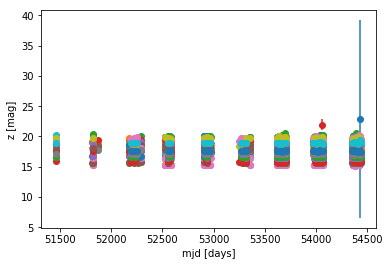

In [68]:
# Plot all the data from the light curves
# to show that there are no catastrophic outliers
for name in object_table['name'].data.data : 
    row = object_table['name'].data.data == name 
    
    if object_table['patchI'].data.data[row] > 0 :
        for proc in ['NCSA', 'IN2P3'] : 
            m1 = object_table[proc+'_patch'].data.data[row] != '0'
            m2 = object_table[proc+'_d2d_arcsec'].data.data[row] < 2.0 
            if m1*m2 : 
                lc = Table.read('photometry_ugriz_'+name+proc+'.txt', format='ascii')
                f = 'z'
                mask = lc['filter'] == f
                plt.errorbar(lc['mjd'][mask],lc['psfMagDered'][mask],
                             lc['psfMagErr'][mask], fmt='o')
                plt.xlabel('mjd [days]')
                plt.ylabel(f +' [mag]')

In [73]:
lc

id,objectId,exposure_id,mjd,psfFlux,psfFluxErr,filter,psfFluxJy,psfFluxErrJy,psfMag,psfMagErr,psfMagDered
int64,int64,int64,float64,float64,float64,str1,float64,float64,float64,float64,float64
177802256115040268,216427881025243905,2649460079,52196.2836599,3.653601701150661e-27,6.57394036006628e-29,z,0.00036536017011506603,6.57394036006628e-06,17.493196997973726,0.01953569557020066,17.551849638889447
178674682151567372,216427881025243905,2662460240,52197.296758,3.640813150242396e-27,6.88497416737007e-29,z,0.0003640813150242396,6.88497416737007e-06,17.497004022179645,0.02053185762043421,17.555656663095366
181761678218625036,216427881025243905,2708460066,52225.146997300006,3.623700817654056e-27,6.173328770523631e-29,z,0.0003623700817654055,6.1733287705236305e-06,17.50211916504711,0.018496578187080278,17.56077180596283
183103875966828556,216427881025243905,2728460371,52231.18299560001,3.590294142514692e-27,6.370061692524599e-29,z,0.00035902941425146914,6.370061692524599e-06,17.512174923653077,0.019263621117328843,17.5708275645688
185788211669237772,216427881025243905,2768460090,52253.1689658,3.6366452992426676e-27,8.830292151538118e-29,z,0.0003636645299242667,8.830292151538117e-06,17.498247639646543,0.02636321966707357,17.556900280562264
227127287798038540,216427881025243905,3384460327,52557.2909338,3.47979102502047e-27,7.05895151082319e-29,z,0.00034797910250204694,7.05895151082319e-06,17.54611709085593,0.022024768636466473,17.60476973177165
230684055845208076,216427881025243905,3437460301,52578.18693710001,3.577155544256664e-27,7.345000849676842e-29,z,0.00035771555442566633,7.345000849676841e-06,17.516155437897307,0.02229350456755307,17.574808078813028
277056266105257996,216427881025243905,4128460081,52908.2655102,3.685679016260475e-27,9.685268845490039e-29,z,0.00036856790162604746,9.685268845490039e-06,17.483706224838535,0.028531098318577353,17.542358865754256
278733986967060492,216427881025243905,4153460070,52911.2791241,3.647764782075574e-27,7.612473173174902e-29,z,0.00036477647820755735,7.612473173174902e-06,17.49493293486408,0.02265808851623141,17.553585575779802


Compress all photometry as a single archive : 
    
    tar --create --gzip --file Stripe82_dCs_lc.tar.gz  photometry_ugriz_*
    
    
or

    tar czf Stripe82_dCs_lc.tar.gz  photometry_ugriz_*

Copy that over to mac ( on Mac terminal ):  
    
     
    scp suberlak@gateway.phys.washington.edu:/astro/users/suberlak/SDSS_S82_FP_research/code/Stripe82_dCs_lc.tar.gz .

### Fold on a given period 

#### Example from Jake VdP using Sesar2010 RR Lyr 

In [ ]:
%matplotlib inline
#https://www.astroml.org/gatspy/periodic/lomb_scargle_multiband.html

# Fetch the RRLyrae data
from gatspy import datasets, periodic
rrlyrae = datasets.fetch_rrlyrae()

# Get data from first lightcurve
lcid = rrlyrae.ids[0]
t, mag, dmag, filts = rrlyrae.get_lightcurve(lcid)
Nobs = len(t)
rng = np.random.RandomState(0)
dy = 0.06 + 0.01 * rng.randn(Nobs)
mags = np.array([rrlyrae.generated(band, t, err=dy, corrected=False)
                 for band in 'ugriz'])

# Fit the Lomb-Scargle model
model = periodic.LombScargleMultibandFast(fit_period=True)
model.optimizer.period_range = (0.2, 1.2)
model.fit(t, mag, dmag, filts)

# Predict on a regular phase grid
tfit = np.linspace(0, model.best_period, 1000)
filtsfit = np.array(list('ugriz'))[:, np.newaxis]
magfit = model.predict(tfit, filts=filtsfit)

# Plot the results
phase = (t / model.best_period) % 1
phasefit = (tfit / model.best_period)

fig, ax = plt.subplots()
for i, filt in enumerate('ugriz'):
    mask = (filts == filt)
    errorbar = ax.errorbar(phase[mask], mag[mask], dmag[mask], fmt='.')
    ax.plot(phasefit, magfit[i], color=errorbar.lines[0].get_color())
ax.set(xlabel='phase', ylabel='magnitude')
ax.invert_yaxis()

In [ ]:
periods = np.linspace(0.2,1.2,1000)
scores = model.periodogram(periods=periods)
plt.scatter(periods, scores)

In [ ]:
#https://www.astroml.org/gatspy/periodic/lomb_scargle_multiband.html
import matplotlib as mpl
from gatspy import datasets, periodic
mpl.style.use('ggplot')
mpl.rc('axes', color_cycle=["#4C72B0", "#55A868", "#C44E52",
                            "#8172B2", "#CCB974"])

# Choose a Sesar 2010 object to base our fits on
lcid = 1019544
rrlyrae = datasets.RRLyraeGenerated(lcid, random_state=0)

# Generate data in a 6-month observing season
Nobs = 60
rng = np.random.RandomState(0)
nights = np.arange(180)
rng.shuffle(nights)
nights = nights[:Nobs]
t = 57000 + nights + 0.05 * rng.randn(Nobs)
dy = 0.06 + 0.01 * rng.randn(Nobs)
mags = np.array([rrlyrae.generated(band, t, err=dy, corrected=False)
                 for band in 'ugriz'])



In [ ]:
mags = mags[np.arange(Nobs) % 5, np.arange(Nobs)]

In [ ]:
filts = np.take(list('ugriz'), np.arange(Nobs), mode='wrap')

In [ ]:
filts

In [ ]:
# Alternate between the five bands. Because the times are randomized,
# the filter orders will also be randomized.
filts = np.take(list('ugriz'), np.arange(Nobs), mode='wrap')
mags = mags[np.arange(Nobs) % 5, np.arange(Nobs)]
masks = [(filts == band) for band in 'ugriz']


periods = np.linspace(0.2, 0.9, 1000)
model = periodic.NaiveMultiband(BaseModel=periodic.LombScargleFast)
model.fit(t, mags, dy, filts)
P = model.scores(periods)

fig = plt.figure(figsize=(10, 4))
gs = plt.GridSpec(5, 2, left=0.07, right=0.95, bottom=0.15,
                  wspace=0.1, hspace=0.6)
ax = [fig.add_subplot(gs[:, 0]),
      fig.add_subplot(gs[:-2, 1]),
      fig.add_subplot(gs[-2:, 1])]

for band, mask in zip('ugriz', masks):
    ax[0].errorbar((t[mask] / rrlyrae.period) % 1, 
                   mags[mask], dy[mask],
                   fmt='.', label=band)
ax[0].set_ylim(18, 14.5)
ax[0].legend(loc='upper left', fontsize=12, ncol=3)
ax[0].set_title('Folded Data, 1 band per night (P={0:.3f} days)'
                ''.format(rrlyrae.period), fontsize=12)
ax[0].set_xlabel('phase')
ax[0].set_ylabel('magnitude')

for i, band in enumerate('ugriz'):
    offset = 4 - i
    ax[1].plot(periods, P[band] + offset, lw=1)
    ax[1].text(0.89, 1 + offset, band, fontsize=10,
               ha='right', va='top')
    
ax[1].set_title('Standard Periodogram in Each Band', fontsize=12)
ax[1].yaxis.set_major_formatter(plt.NullFormatter())
ax[1].xaxis.set_major_formatter(plt.NullFormatter())
ax[1].set_ylabel('power + offset')

LS_multi = periodic.LombScargleMultiband(Nterms_base=1, Nterms_band=0)
LS_multi.fit(t, mags, dy, filts)
P_multi = LS_multi.periodogram(periods)
ax[2].plot(periods, P_multi, lw=1, color='gray')

ax[2].set_title('Multiband Periodogram', fontsize=12)
ax[2].set_yticks([0, 0.5, 1.0])
ax[2].set_ylim(0, 1.0)
ax[2].yaxis.set_major_formatter(plt.NullFormatter())
ax[2].set_xlabel('Period (days)')
ax[2].set_ylabel('power')

#### Using the Carbon star SDSS data 

In [ ]:
data = Table.read('photometry_ugriz_J013007.13+002635.4.txt', format='ascii')
t, mag, dmag, filts = data['mjd'], data['psfMagDered'], data['psfMagErr'], data['filter']

# Fit the Lomb-Scargle model
model = periodic.LombScargleMultibandFast(fit_period=True)
model.optimizer.period_range = (1, 3) # range in days 
model.fit(t, mag, dmag, filts)

# Predict on a regular phase grid
tfit = np.linspace(0, model.best_period, 1000)
filtsfit = np.array(list('ugriz'))[:, np.newaxis]
magfit = model.predict(tfit, filts=filtsfit)

# Plot the results
phase = (t / model.best_period) % 1
phasefit = (tfit / model.best_period)

fig, ax = plt.subplots()
for i, filt in enumerate('ugriz'):
    mask = (filts == filt)
    errorbar = ax.errorbar(phase[mask], mag[mask], dmag[mask], fmt='.')
    ax.plot(phasefit, magfit[i], color=errorbar.lines[0].get_color())
ax.set(xlabel='phase', ylabel='magnitude')
ax.invert_yaxis()

We don't find anything here - check what it looks like when folded on chosen  period:

In [ ]:
# choose a period to fold the star on 
period = 3 # days 

# Grab photometry for the star
t, mag, dmag, filts = data['mjd'], data['psfMagDered'], data['psfMagErr'], data['filter']

# define function to phase lightcurves
def phase(time, period, t0 = None):
    """ Given an input array of times and a period, return the corresponding phase."""
    if t0 is None:
        t0 = time[0]
        phase = ((time - t0) % period)/period
    return phase 

# define function to plot phased lc
def plot_phased_lc(mjds, mags, magerrs, period, t0=None, ax = None,f=None):
    phases = phase(mjds, period, t0) 
    ax.errorbar(phases, mags, magerrs, fmt = '_', capsize=0, label=f)
    ax.set_xlabel('Phase')
    ax.set_ylabel('Magnitude')
    plt.gca().invert_yaxis()
    
# run function to plot phased lc
fig,ax = plt.subplots(1,1,figsize = (8,8))

for f in 'ugriz':
    mask = filts == f
    tm, m,mErr = t[mask], mag[mask], dmag[mask]
    plot_phased_lc(tm, m, mErr, period, None, ax,f)
plt.legend()
plt.title('Folded on P ='+str(period)+' d')
plt.savefig('carbon_star_phased.png', bbox_inches='tight')